Running v21 Sim (Annotated CUSUM): 50 Users, 60 Steps
Running v21 Sim (Annotated CUSUM): 50 Users, 60 Steps
Noisiest Malicious User: 2 (Peak ITS: 0.9298)


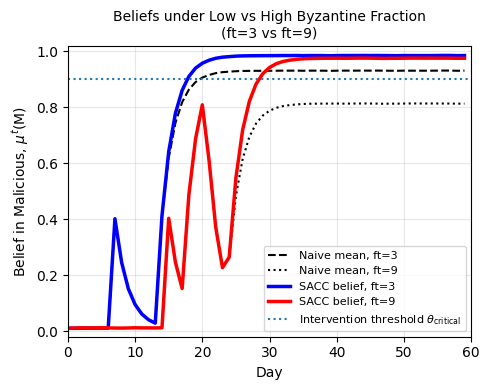

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from dataclasses import dataclass
from enum import Enum
from scipy.stats import beta
import random
import os

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

class UserType(Enum):
    LOYAL = 0
    DISGRUNTLED = 1 
    MALICIOUS = 2
    NEGLIGENT = 3 

@dataclass
class ChannelMetadata:
    index: int
    name: str
    category: str
    severity: float

# Experiment Config
NUM_USERS = 50
PCT_MAL = .1    # 20% Malicious (10 users)
HORIZON = 60
THRESHOLD = 0.9 
N_MEMBERS = 25    
#ft = 3  
SACC_GAMMA = 0.05 # Clipping radius
# =====================================================================
# Signal-generation parameters (Beta distributions)
# =====================================================================
NORMAL_ALPHA, NORMAL_BETA = 3.5, 6.5   # mean ≈ 0.35
RECON_ALPHA,  RECON_BETA  = 5.0, 5.0   # mean 0.50
EXFIL_ALPHA,  EXFIL_BETA  = 8.0, 2.0   # mean 0.80

# ============================================================================
# 2. CAUSAL DBN ENGINE
# ============================================================================

class CausalDependencyDBN:
    def __init__(self, channels):
        self.channels = channels
        # Likelihood params (Alpha, Beta)
        self.params = {
            UserType.LOYAL:      {'a': 2, 'b': 15}, 
            UserType.NEGLIGENT:  {'a': 3, 'b': 10}, 
            UserType.DISGRUNTLED:{'a': 5, 'b': 8},  
            UserType.MALICIOUS:  {'a': 12, 'b': 3}, 
        }

    def compute_log_likelihood(self, signals, user_type):
        log_prob = 0.0
        p = self.params.get(user_type, self.params[UserType.LOYAL])
        for idx, val in enumerate(signals):
            val = np.clip(val, 0.01, 0.99)
            log_prob += np.log(beta.pdf(val, p['a'], p['b']) + 1e-9)
        return log_prob

    def compute_threat_score(self, signals):
        score, weights = 0.0, 0.0
        for name, meta in self.channels.items():
            val = signals[meta.index]
            w = meta.severity
            if val > 0.6: w *= 1.5 
            if val > 0.8: w *= 2.0
            score += val * w
            weights += w
        return score / weights if weights > 0 else 0


# ============================================================================
# 6. VISUALIZATION SUITE
# ============================================================================

class VisualizationSuite:
    @staticmethod
    def generate_all(df):
        VisualizationSuite.plot_fig1_separation(df)
        VisualizationSuite.plot_fig2_byz_robustness(df)
        #VisualizationSuite.plot_fig2_sacc_efficacy(df)
        #VisualizationSuite.plot_fig3_actions(df)
        #VisualizationSuite.plot_fig4_drift(df)

    @staticmethod
    def plot_fig1_separation(df):
        fig, axes = plt.subplots(2, 1, figsize=(5, 8))
        
        # Panel (a): Threat Score Separation
        ax = axes[0]
        targets = df[df['IsTarget']==True]
        baseline = df[df['IsTarget']==False]
        
        t_mean = targets.groupby('Day')['ITS'].mean()
        t_std = targets.groupby('Day')['ITS'].std()
        b_mean = baseline.groupby('Day')['ITS'].mean()
        b_std = baseline.groupby('Day')['ITS'].std()
        
        ax.plot(t_mean, 'r-', linewidth=2, label='Malicious Cohort')
        ax.fill_between(t_mean.index, t_mean - t_std, t_mean + t_std, color='r', alpha=0.15)
        ax.plot(b_mean, 'g--', linewidth=2, label='Loyal Baseline')
        ax.fill_between(b_mean.index, b_mean - b_std, b_mean + b_std, color='g', alpha=0.1)
        
        ax.axhline(THRESHOLD, color='orange', linestyle=':', linewidth=2, label='Threshold')
        ax.set_title(f"(a) Traitor-invariant ITS  (traitors: {ft})", fontsize=10)
        ax.set_ylabel("Insider Threat Score")
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, HORIZON)
        
        # Panel (b): CUSUM (Malicious Only) - RANDOM SAMPLE
        ax = axes[1]
        all_mal_ids = targets['AgentID'].unique()
        n_sample = min(5, len(all_mal_ids))
        targets_to_plot = np.random.choice(all_mal_ids, n_sample, replace=False)
        
        for uid in targets_to_plot:
            d = targets[targets['AgentID']==uid]
            ax.plot(d['Day'], d['CUSUM'], linewidth=1.5, label=f'User {uid}')
        
        # === ANNOTATIONS ===
        # Assuming attack generally starts around day 10-15
        # Mark Normal Phase (Negative drift)
        ax.annotate("Normal Phase", xy=(5, 60), xytext=(5, 300),
                    arrowprops=dict(facecolor='green', shrink=0.05), fontsize=8, color='green')
        
        # Mark Attack Phase (Positive drift)
        ax.annotate("Attack Phase", xy=(20, 250), xytext=(20, 500),
                    arrowprops=dict(facecolor='red', shrink=0.05), fontsize=8, color='red')
            
        ax.set_title(f"(b) Cum Log-Odds (traitors: {ft})", fontsize=10)
        ax.set_xlabel("Simulation Day")
        ax.set_ylabel("Log-Likelihood Ratio")
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, HORIZON)
        
        plt.tight_layout()
        plt.savefig("fig1-dynamics.png")

    @staticmethod
    def find_suspicious_spikes(series, min_height=0.15, min_drop=0.10, window=5):
        """
        Detect 'suspicious' peaks in a 1D time series.

        A point i is flagged as a spike if:
          - series[i] >= min_height,
          - series[i] is a local maximum (>= neighbors),
          - within the next `window` steps, the value drops by at least `min_drop`.

        Returns
        -------
        list of int
            Indices of detected spike locations.
        """
        import numpy as np

        s = np.asarray(series, dtype=float)
        n = len(s)
        spikes = []

        for i in range(1, n - window - 1):
            if s[i] < min_height:
                continue
            if not (s[i] >= s[i - 1] and s[i] >= s[i + 1]):
                continue
            future_min = np.min(s[i+1:i+1+window])
            if s[i] - future_min >= min_drop:
                spikes.append(i)

        return spikes


    @staticmethod
    def plot_fig2_byz_robustness(df):
        """
        Figure 2: Robustness to Byzantine certifiers for a representative
        malicious user. Shows how the system belief tracks the honest
        consensus while the naive belief is suppressed by traitors.
        """
        fig, ax = plt.subplots(figsize=(5, 4))

        # Focus on malicious targets only
        targets = df[df['IsTarget'] == True]

        # Reuse your helper: highest peak ITS = "noisiest" malicious user
        uid = VisualizationSuite.get_noisiest_malicious_user(targets)
        if uid is None:
            print("No malicious user found for robustness plot.")
            return

        d = df[df['AgentID'] == uid].copy()

        # Smooth honest mean slightly for readability (proxy anchor)
        honest_smooth = d['Honest_Mean'].rolling(3, min_periods=1).mean()

        # --- NEW: shaded band for anchor ± gamma -------------------------
        # If your gamma is called something else (e.g. CLIP_GAMMA), swap it in.
        band_lower = np.clip(honest_smooth - SACC_GAMMA, 0.0, 1.0)
        band_upper = np.clip(honest_smooth + SACC_GAMMA, 0.0, 1.0)

        ax.fill_between(
            d['Day'],
            band_lower,
            band_upper,
            alpha=0.2,
            label=r"Anchor $\pm \gamma$"
        )
        # -----------------------------------------------------------------

        # Core curves: honest (proxy anchor), naive with traitors, system belief
        ax.plot(
            d['Day'],
            honest_smooth,
            'b:',
            linewidth=1.5,
            label='Honest mean (proxy anchor)'
        )
        ax.plot(
            d['Day'],
            d['Naive_Smooth'],
            'k--',
            linewidth=2,
            label='Naive mean w/ traitors'
        )
        ax.plot(
            d['Day'],
            d['P_Detect'],
            'r-',
            linewidth=2.5,
            label='System belief (robust)'
        )

        # Intervention threshold
        ax.axhline(
            THRESHOLD,
            linestyle=':',
            linewidth=1.5,
            label=r'Intervention threshold $\theta_{\mathrm{critical}}$'
        )

        # -------- NEW: arrow probe for suspicious spike -----------------
        # Use system belief for spikes; you can switch to honest_smooth if preferred.
        # -------- mark negligence peaks: one label, arrows to each peak -----
        spikes = VisualizationSuite.find_suspicious_spikes(
            d['P_Detect'].values,
            #honest_smooth.values,
            min_height=0.15,
            min_drop=0.10,
            window=5,
        )

        if spikes:
            # choose the highest spike as the canonical negligence episode
            best_idx = max(spikes, key=lambda i: d['P_Detect'].iloc[i])
            x_spike = d['Day'].iloc[best_idx]
            y_spike = d['P_Detect'].iloc[best_idx]

            # nice-looking label position (tweak if needed)
            x_label = min(x_spike - 5, 10)
            y_label = min(y_spike + .1, 0.95)

            # small circle on the red curve
            """ax.scatter(
                x_spike,
                y_spike,
                s=30,
                facecolors='none',
                edgecolors='red',
                linewidths=1.2,
                zorder=5,
            )"""

            # one arrow + text
            ax.annotate(
                'traitor suppression',
                xy=(x_spike, y_spike),
                xytext=(x_label, y_label),
                textcoords='data',
                fontsize=8,
                ha='left',
                va='bottom',
                arrowprops=dict(
                    arrowstyle='->',
                    linewidth=1.0,
                ),
            )

        ax.set_title(f"Robustness to Byzantine Certifiers (traitors: {ft})",
                    fontsize=10)
        ax.set_xlabel("Day")
        ax.set_ylabel(r"Belief in Malicious, $\mu^t(\mathrm{M})$")
        ax.set_xlim(0, HORIZON)
        ax.set_ylim(-0.02, 1.02)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=8)

        plt.tight_layout()
        plt.savefig("fig2-byz-robustness.png")
        plt.show()
        plt.close()



    @staticmethod
    def get_noisiest_malicious_user(df):
        """
        Identifies the malicious user with the highest peak Insider Threat Score (ITS).
        """
        # Filter for Malicious users only
        malicious_df = df[df['Type'] == 'MALICIOUS']
        
        if malicious_df.empty:
            print("No malicious users found in the logs.")
            return None

        # Group by AgentID and find the max ITS for each agent
        max_scores = malicious_df.groupby('AgentID')['ITS'].max()
        
        # Find the AgentID with the highest maximum score
        noisiest_uid = max_scores.idxmax()
        peak_score = max_scores.max()
        
        print(f"Noisiest Malicious User: {noisiest_uid} (Peak ITS: {peak_score:.4f})")
        return noisiest_uid

# Example Usage:
# df = flatten_simulation_results(results)
# target_uid = get_noisiest_malicious_user(df)
    @staticmethod
    def plot_fig2_sacc_efficacy(df):
        fig, ax = plt.subplots(figsize=(5, 4))
        
        # Panel (a): SACC vs Naive - Single Representative (Randomly chosen)
        targets = df[df['IsTarget']==True]
        #all_mal_ids = targets['AgentID'].unique()
        uid = VisualizationSuite.get_noisiest_malicious_user(targets)
        d = df[df['AgentID']==uid]
        
        # Plot Honest Mean (Baseline Truth - Smoothed slightly for viz if noisy)
        honest_smooth = d['Honest_Mean'].rolling(3, min_periods=1).mean()
        ax.plot(d['Day'], honest_smooth, 'b:', linewidth=1.5, label='Honest Votes (Truth)')

        ax.plot(d['Day'], d['Naive_Smooth'], 'k--', linewidth=2, label='Naive (Suppressed)')
        ax.plot(d['Day'], d['P_Detect'], 'r-', linewidth=2.5, label='SACC (Robust)')
        
        ax.fill_between(d['Day'], d['Naive_Smooth'], d['P_Detect'],
                        color='green', alpha=0.2, label='SACC Protection')
        
        ax.axhline(THRESHOLD, color='orange', linestyle=':', label='Thresh')
        ax.set_title(f"(b) SACC Efficacy (User {uid})", fontsize=10)
        ax.set_xlabel("Day")
        ax.set_ylabel("System Belief")
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, HORIZON)
        
        plt.tight_layout()
        plt.savefig("fig2-resilience.png")

    @staticmethod
    def plot_fig3_actions(df):
        fig, ax = plt.subplots(figsize=(5, 4))
        act = df[df['IsTarget']==True].groupby(['Day','Action']).size().unstack(fill_value=0)
        cols = ['NORMAL', 'RECON', 'EXFIL']
        act = act[cols] if set(cols).issubset(act.columns) else act
        act.plot(kind='bar', stacked=True, ax=ax, width=1.0, color=['#3498db', '#e67e22', '#e74c3c'])
        ax.set_xticks(np.arange(0, HORIZON, 10))
        ax.set_title("Malicious Cohort Actions")
        plt.tight_layout()
        plt.savefig("fig3-actions.png")

    @staticmethod
    def plot_fig4_drift(df):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))
        targets = df[df['IsTarget']==True]
        for uid in targets['AgentID'].unique()[:5]:
            d = targets[targets['AgentID']==uid]
            ax1.plot(d['Day'], d['RefPoint'])
            ax2.plot(d['Day'], d['Beta'])
        ax1.set_title("Reference Point Drift")
        ax2.set_title("Beta Decay")
        plt.tight_layout()
        plt.savefig("fig4-drift.png")

# ============================================================
# Ablation-ready overrides: UserAgent + ByzantineCommittee
# ============================================================

import numpy as np
import random

# Global toggles (default matches your original behavior)
BEHAVIOR_MODE = "behavioral"   # 'behavioral' or 'rational'
AGG_MODE      = "anchor_clip"  # 'anchor_clip', 'average', 'median'


class UserAgent:
    def __init__(self, uid, is_malicious_scenario):
        self.uid = uid
        self.is_target = is_malicious_scenario
        self.type = UserType.LOYAL
        self.time = 0

        # Stochastic start / peak times for attack progression
        self.start_day = np.random.randint(5, 15) if is_malicious_scenario else 999
        self.peak_day  = self.start_day + np.random.randint(8, 15)

        # Behavioral state (continuous “mood” variables)
        self.stress = 0.0
        self.ref_point = 0.0
        self.beta = 0.95

        # Intrinsic payoff parameters (match your original theta)
        self.theta = {
            "trust_utility":  2.0,
            "attack_utility": 25.0,
            "detection_cost": 8.0,
        }

        self.current_action = "NORMAL"
        self.cumulative_llr = 0.0

    def update_state(self, t):
        self.time = t
        if not self.is_target:
            return

        # ----- Rational benchmark: freeze behavioral dynamics -----
        if BEHAVIOR_MODE == "rational":
            self.type = UserType.MALICIOUS
            self.stress = 1.0
            self.ref_point = 0.0    # neutral reference
            self.beta = 1.0         # no extra "temperature"
            return

        # ----- Original behavioral evolution -----
        if t < self.start_day:
            self.type = UserType.LOYAL

        elif self.start_day <= t < self.peak_day:
            self.type = UserType.DISGRUNTLED
            progress = (t - self.start_day) / (self.peak_day - self.start_day)
            self.stress = progress
            self.ref_point = 3.0 * progress
            self.beta = 0.95 - (0.4 * progress)

        else:
            self.type = UserType.MALICIOUS
            self.stress = 1.0
            self.ref_point = 5.0
            self.beta = 0.5

    def choose_action(self, current_belief):
        # Loyal users behave normally
        if self.type == UserType.LOYAL:
            self.current_action = "NORMAL"
            return self.current_action

        # Disgruntled users: noisy recon vs normal
        if self.type == UserType.DISGRUNTLED:
            prob_recon = 0.1 + 0.5 * self.stress
            self.current_action = (
                "RECON" if np.random.random() < prob_recon else "NORMAL"
            )
            return self.current_action

        # Malicious regime: trade off attack vs detection
        p_mal = current_belief
        risk_tolerance = 0.2 + 0.1 * self.ref_point

        risk_term = self.theta["detection_cost"] * p_mal * (1.0 / risk_tolerance)
        u_attack = self.theta["attack_utility"] - risk_term
        u_normal = self.theta["trust_utility"]

        # ----- Rational mode: deterministic best reply -----
        if BEHAVIOR_MODE == "rational":
            self.current_action = "EXFIL" if u_attack >= u_normal else "RECON"
            return self.current_action

        # ----- Behavioral mode: softmax with inverse temperature 1/beta -----
        vals = np.array([u_normal, u_attack])
        inv_temp = 1.0 / self.beta
        probs = np.exp(vals * inv_temp) / np.sum(np.exp(vals * inv_temp))

        self.current_action = (
            "EXFIL" if np.random.random() < probs[1] else "RECON"
        )
        return self.current_action

    """def generate_signals(self, action):
        num_channels = 4
        # HIGHLY NOISY
        if action == "NORMAL":
            # mean ~ <0.45
            return np.random.beta(3.5, 6.5, size=num_channels)

        if action == "RECON":
            # mean ~ 0.50
            return np.random.beta(5, 5, size=num_channels)

        if action == "EXFIL":
            # mean ~ >0.55
            return np.random.beta(8, 2, size=num_channels)
        return np.random.beta(5, 5, size=num_channels)
    """

    def generate_signals(self, action):
        num_channels = 4

        if action == "NORMAL":
            return np.random.beta(NORMAL_ALPHA, NORMAL_BETA, size=num_channels)

        if action == "RECON":
            return np.random.beta(RECON_ALPHA, RECON_BETA, size=num_channels)

        if action == "EXFIL":
            return np.random.beta(EXFIL_ALPHA, EXFIL_BETA, size=num_channels)

        # fallback: treat any other action like RECON
        return np.random.beta(RECON_ALPHA, RECON_BETA, size=num_channels)



class ByzantineCommittee:
    """
    Same structure as your original, but the aggregation step depends on AGG_MODE:
      - 'anchor_clip': clipped SACC (your baseline)
      - 'average':     naive mean of reports
      - 'median':      coordinate-wise median of reports
    """

    def __init__(self, channels):
        self.dbn = CausalDependencyDBN(channels)
        self.user_beliefs = {}
        self.naive_beliefs = {}
        self.belief_history = {}

    def initialize_user(self, uid):
        self.user_beliefs[uid] = 0.01
        self.naive_beliefs[uid] = 0.01
        self.belief_history[uid] = {
            "anchor": [],
            "sacc": [],
            "naive_smooth": [],
            "traitor_vote": [],
            "honest_votes": [],
        }

    def certify(self, uid, signals, ft, is_malicious: bool = False):
        if uid not in self.user_beliefs:
            self.initialize_user(uid)

        prior = self.user_beliefs[uid]
        naive_prior = self.naive_beliefs[uid]

        # 1. Anchor update (Bayes with true likelihoods)
        ll_m = self.dbn.compute_log_likelihood(signals, UserType.MALICIOUS)
        ll_l = self.dbn.compute_log_likelihood(signals, UserType.LOYAL)
        likelihood_ratio = np.exp(ll_m - ll_l)
        anchor_post = (prior * likelihood_ratio) / (
            (prior * likelihood_ratio) + (1 - prior)
        )

        # 2. Committee voting: honest votes around anchor + Byzantine under-reporting
        reports = []
        honest_reports = []
        HONEST_NOISE_BASE   = 0.005  # noise when anchor is near 0
        HONEST_NOISE_SLOPE  = 0.02   # extra noise as belief rises
        LOYAL_NOISE_CUTOFF  = 0.65    # don't add extra noise below this

        for _ in range(N_MEMBERS - ft):
            # extra noise kicks in only when anchor > 0.5
            extra = max(anchor_post - LOYAL_NOISE_CUTOFF, 0.0)
            sigma = HONEST_NOISE_BASE + HONEST_NOISE_SLOPE * extra
            vote = np.clip(anchor_post + np.random.normal(0, sigma), 0.01, 0.99)
            reports.append(vote)
            honest_reports.append(vote)

        # --- traitor votes: mimic when anchor is low, sabotage when anchor is high ---
        risk_band_low  = THRESHOLD - SACC_GAMMA   # “getting close” to threshold
        #risk_band_high = THRESHOLD + SACC_GAMMA   # clearly in high-risk regime

        traitor_votes = []

        for _ in range(ft):
            if not is_malicious:
                # LOYAL USER: traitors blend in and look honest
                vote = np.clip(anchor_post + np.random.normal(0, 0.02), 0.01, 0.99)

            else:
                # MALICIOUS USER: traitors try to hide the attack
                if anchor_post < risk_band_low:
                    # Early malicious / low anchor: still blend in
                    vote = np.clip(anchor_post + np.random.normal(0, 0.02), 0.01, 0.99)
                else:
                    # Near or above threshold: aggressively under-report
                    # SACC will clip this to (anchor_post - SACC_GAMMA),
                    # maximizing downward pull inside the allowed band.
                    vote = anchor_post - 10 * SACC_GAMMA

            reports.append(vote)
            traitor_votes.append(vote)

        traitor_vote = float(np.mean(traitor_votes)) if traitor_votes else float("nan")
        raw_naive_mean = float(np.mean(reports))

        # 3. Aggregation rule selected by AGG_MODE
        if AGG_MODE == "anchor_clip":
            clipped_reports = []
            for r in reports:
                if abs(r - anchor_post) > SACC_GAMMA:
                    if r < anchor_post:
                        clipped_reports.append(anchor_post - SACC_GAMMA)
                    else:
                        clipped_reports.append(anchor_post + SACC_GAMMA)
                else:
                    clipped_reports.append(r)
            core_mean = float(np.mean(clipped_reports))

        elif AGG_MODE == "median":
            core_mean = float(np.median(reports))

        elif AGG_MODE == "average":
            core_mean = raw_naive_mean

        else:
            # Fallback to original clipped mean
            clipped_reports = []
            for r in reports:
                if abs(r - anchor_post) > SACC_GAMMA:
                    if r < anchor_post:
                        clipped_reports.append(anchor_post - SACC_GAMMA)
                    else:
                        clipped_reports.append(anchor_post + SACC_GAMMA)
                else:
                    clipped_reports.append(r)
            core_mean = float(np.mean(clipped_reports))

        # 4. Inertia / smoothing
        alpha = 0.4
        system_belief = (1 - alpha) * prior + alpha * core_mean
        naive_belief_smooth = (1 - alpha) * naive_prior + alpha * raw_naive_mean

        self.user_beliefs[uid] = system_belief
        self.naive_beliefs[uid] = naive_belief_smooth

        # 5. Log histories for later analysis
        self.belief_history[uid]["anchor"].append(anchor_post)
        self.belief_history[uid]["sacc"].append(system_belief)
        self.belief_history[uid]["naive_smooth"].append(naive_belief_smooth)
        self.belief_history[uid]["traitor_vote"].append(traitor_vote)
        self.belief_history[uid]["honest_votes"].append(honest_reports)

        return system_belief


# ============================================================================
# 5. SIMULATION LOOP
# ============================================================================

def run_simulation(ft):
    channels = {
        's_logon': ChannelMetadata(0, 's_logon', 'Access', 0.6),
        's_file': ChannelMetadata(1, 's_file', 'Recon', 0.7),
        's_role': ChannelMetadata(2, 's_role', 'Priv', 0.9),
        's_exfil': ChannelMetadata(3, 's_exfil', 'Exfil', 0.9)
    }
    
    committee = ByzantineCommittee(channels)
    logs = []
    n_mal = int(NUM_USERS * PCT_MAL)
    
    agents = [UserAgent(i, is_malicious_scenario=(i < n_mal)) for i in range(NUM_USERS)]

    print(f"Running v21 Sim (Annotated CUSUM): {NUM_USERS} Users, {HORIZON} Steps")

    for t in range(HORIZON):
        for uid in range(NUM_USERS):
            agent = agents[uid]
            agent.update_state(t)
            
            # Action & Signals
            current_belief = committee.user_beliefs.get(uid, 0.01)
            action = agent.choose_action(current_belief)
            signals = agent.generate_signals(action)
            
            # CUSUM Logic
            ll_mal = committee.dbn.compute_log_likelihood(signals, UserType.MALICIOUS)
            ll_loy = committee.dbn.compute_log_likelihood(signals, UserType.LOYAL)
            llr = ll_mal - ll_loy
            agent.cumulative_llr += llr 

            # Ground-truth malicious flag for this period
            is_malicious = (agent.type == UserType.MALICIOUS)
            
            p_mal = committee.certify(uid, signals, ft, is_malicious=is_malicious)
            its = committee.dbn.compute_threat_score(signals)
            hist = committee.belief_history[uid]

            # Helper to get mean of honest votes for logging/viz if needed
            honest_mean = np.mean(hist['honest_votes'][-1]) if hist['honest_votes'] else 0.0
            
            logs.append({
                'Day': t,
                'AgentID': uid,
                'Type': agent.type.name,
                'Action': action,
                'ITS': its,
                'RefPoint': agent.ref_point,
                'Beta': agent.beta,
                'P_Detect': p_mal,
                'Naive_Smooth': hist['naive_smooth'][-1],
                'IsTarget': agent.is_target,
                'Signals_Mean': np.mean(signals),
                'Traitor_Vote': hist['traitor_vote'][-1],
                'CUSUM': agent.cumulative_llr,
                'Honest_Mean': honest_mean
            })
            
    return pd.DataFrame(logs)

def plot_belief_updates_ft_sweep(ft_low, df_low, ft_high, df_high):
    """
    Compare belief updates for the same malicious scenario under
    a low vs high number of Byzantine certifiers.

    - Runs the simulation twice (ft_low, ft_high)
    - Picks a canonical malicious user (noisiest in low-ft run)
    - Overlays Naive vs SACC belief trajectories for both runs
    """

    # Pick a canonical malicious user based on the low-traitor run
    targets_low = df_low[df_low["IsTarget"] == True]
    if targets_low.empty:
        print("No malicious users found in low-traitor run.")
        return

    uid = VisualizationSuite.get_noisiest_malicious_user(targets_low)

    d_low = df_low[df_low["AgentID"] == uid]
    d_high = df_high[df_high["AgentID"] == uid]

    fig, ax = plt.subplots(figsize=(5, 4))

    # ---- Naive beliefs ----
    ax.plot(
        d_low["Day"],
        d_low["Naive_Smooth"],
        "k--",
        linewidth=1.5,
        label=f"Naive mean, ft={ft_low}",
    )
    ax.plot(
        d_high["Day"],
        d_high["Naive_Smooth"],
        "k:",
        linewidth=1.5,
        label=f"Naive mean, ft={ft_high}",
    )

    # ---- Robust beliefs (SACC) ----
    ax.plot(
        d_low["Day"],
        d_low["P_Detect"],
        "b-",
        linewidth=2.5,
        label=f"SACC belief, ft={ft_low}",
    )
    ax.plot(
        d_high["Day"],
        d_high["P_Detect"],
        "r-",
        linewidth=2.5,
        label=f"SACC belief, ft={ft_high}",
    )

    # Intervention threshold
    ax.axhline(
        THRESHOLD,
        linestyle=":",
        linewidth=1.5,
        label=r"Intervention threshold $\theta_{\mathrm{critical}}$",
    )

    ax.set_title(
        f"Beliefs under Low vs High Byzantine Fraction\n(ft={ft_low} vs ft={ft_high})",
        fontsize=10,
    )
    ax.set_xlabel("Day")
    ax.set_ylabel(r"Belief in Malicious, $\mu^t(\mathrm{M})$")
    ax.set_xlim(0, HORIZON)
    ax.set_ylim(-0.02, 1.02)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower right", fontsize=8)

    plt.tight_layout()
    plt.savefig(f"fig2-byz-sweep-ft{ft_low}-ft{ft_high}.png")
    plt.show()
    plt.close()

# ============================================================================
# 7. MAIN
# ============================================================================

def run_and_tag(ft_value):
    """
    Run the simulation with a given number of traitors (ft_value)
    and attach that ft_value as a column on the resulting DataFrame.
    """
    df = run_simulation(ft_value)
    df["ft"] = ft_value
    return df

ft_low = 3
df_low = run_and_tag(ft_low)
ft_high = 9
df_high = run_and_tag(ft_high)

# NEW: compare low vs high traitor settings on a single plot
plot_belief_updates_ft_sweep(ft_low, df_low, ft_high, df_high)


In [ ]:
# ============================================================
# Metrics + ablation runners
# ============================================================

import math
import pandas as pd

def _compute_per_user_exfil_times(df, threshold):
    """
    For each user, compute (is_target, t_exfil, t_det).

    t_exfil: first time Action == 'EXFIL' (or None).
    t_det:   first time P_Detect >= threshold (or None).
    """
    per_user = {}
    for uid, d in df.groupby("AgentID"):
        d = d.sort_values("Day")
        is_target = bool(d["IsTarget"].iloc[0])

        # First EXFIL event for this user
        exfil_rows = d[d["Action"] == "EXFIL"]
        t_exfil = int(exfil_rows["Day"].iloc[0]) if not exfil_rows.empty else None

        # First time the system crosses the detection threshold
        det_rows = d[d["P_Detect"] >= threshold]
        t_det = int(det_rows["Day"].iloc[0]) if not det_rows.empty else None

        per_user[uid] = (is_target, t_exfil, t_det)
    return per_user

def summarize_behavior_vs_rational(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group by mode and compute mean and standard error for each metric.

    Output columns (index = mode):

      obedience_rate_mean, obedience_rate_se,
      det_delay_mean, det_delay_se,
      det_early_mean, det_early_se,
      det_fp_mean, det_fp_se,
      agg_fn_mean, agg_fn_se,
      agg_fp_mean, agg_fp_se,
      agg_miss_mean, agg_miss_se,
      agg_honest_mean, agg_honest_se,
      agg_f1_mean, agg_f1_se,
      agg_FP_mean, agg_FP_se,
      agg_FN_mean, agg_FN_se,

      (if present)
      kc_f1_mean, kc_f1_se,
      kc_prec_mean, kc_prec_se,
      kc_rec_mean, kc_rec_se,
      kc_FP_mean, kc_FP_se,
      kc_FN_mean, kc_FN_se.
    """
    grouped = df.groupby("mode")

    def mean_se(col: str) -> pd.DataFrame:
        if col not in df.columns:
            raise KeyError(f"Column not found: {col}")
        m = grouped[col].mean()
        se = grouped[col].sem(ddof=1)  # standard error
        out = pd.concat([m, se], axis=1)
        out.columns = [f"{col}_mean", f"{col}_se"]
        return out

    # Handle old vs new names for malicious-period F1/FP/FN
    col_f1_mal = "agg_f1_mal" if "agg_f1_mal" in df.columns else "agg_f1"
    col_FP_mal = "agg_FP_mal" if "agg_FP_mal" in df.columns else "agg_FP"
    col_FN_mal = "agg_FN_mal" if "agg_FN_mal" in df.columns else "agg_FN"

    parts = [
        mean_se("obedience_rate"),
        mean_se("det_mean_detection_delay"),
        mean_se("det_early_detection_rate"),
        mean_se("det_false_positive_rate"),

        # malicious-type period metrics
        mean_se("agg_fn_period"),
        mean_se("agg_fp_period"),
        mean_se("agg_miss_user"),
        mean_se("agg_honest_dist"),
        mean_se(col_f1_mal),
        mean_se(col_FP_mal),
        mean_se(col_FN_mal),
    ]

    # Kill-chain (RECON+EXFIL) metrics, only if present
    if "agg_f1_kc" in df.columns:
        parts.extend([
            mean_se("agg_f1_kc"),
            mean_se("agg_prec_kc"),
            mean_se("agg_rec_kc"),
            mean_se("agg_FP_kc"),
            mean_se("agg_FN_kc"),
        ])

    summary = pd.concat(parts, axis=1)

    # Build rename map depending on which columns we used
    rename_map = {
        "det_mean_detection_delay_mean": "det_delay_mean",
        "det_mean_detection_delay_se": "det_delay_se",
        "det_early_detection_rate_mean": "det_early_mean",
        "det_early_detection_rate_se": "det_early_se",
        "det_false_positive_rate_mean": "det_fp_mean",
        "det_false_positive_rate_se": "det_fp_se",

        "agg_fn_period_mean": "agg_fn_mean",
        "agg_fn_period_se": "agg_fn_se",
        "agg_fp_period_mean": "agg_fp_mean",
        "agg_fp_period_se": "agg_fp_se",
        "agg_miss_user_mean": "agg_miss_mean",
        "agg_miss_user_se": "agg_miss_se",
        "agg_honest_dist_mean": "agg_honest_mean",
        "agg_honest_dist_se": "agg_honest_se",
    }

    # Malicious-period F1/FP/FN aliases
    if col_f1_mal == "agg_f1_mal":
        rename_map.update({
            "agg_f1_mal_mean": "agg_f1_mean",
            "agg_f1_mal_se": "agg_f1_se",
        })
    else:
        rename_map.update({
            "agg_f1_mean": "agg_f1_mean",
            "agg_f1_se": "agg_f1_se",
        })

    if col_FP_mal == "agg_FP_mal":
        rename_map.update({
            "agg_FP_mal_mean": "agg_FP_mean",
            "agg_FP_mal_se": "agg_FP_se",
        })
    else:
        rename_map.update({
            "agg_FP_mean": "agg_FP_mean",
            "agg_FP_se": "agg_FP_se",
        })

    if col_FN_mal == "agg_FN_mal":
        rename_map.update({
            "agg_FN_mal_mean": "agg_FN_mean",
            "agg_FN_mal_se": "agg_FN_se",
        })
    else:
        rename_map.update({
            "agg_FN_mean": "agg_FN_mean",
            "agg_FN_se": "agg_FN_se",
        })

    # Kill-chain renames, if present
    if "agg_f1_kc_mean" in summary.columns:
        rename_map.update({
            "agg_f1_kc_mean": "kc_f1_mean",
            "agg_f1_kc_se": "kc_f1_se",
            "agg_prec_kc_mean": "kc_prec_mean",
            "agg_prec_kc_se": "kc_prec_se",
            "agg_rec_kc_mean": "kc_rec_mean",
            "agg_rec_kc_se": "kc_rec_se",
            "agg_FP_kc_mean": "kc_FP_mean",
            "agg_FP_kc_se": "kc_FP_se",
            "agg_FN_kc_mean": "kc_FN_mean",
            "agg_FN_kc_se": "kc_FN_se",
        })

    summary = summary.rename(columns=rename_map)
    return summary


def _compute_per_user_times(df, threshold):
    """For each user, compute (is_target, t0_mal, t_det).

    t0_mal: first time Type == 'MALICIOUS' (or None).
    t_det:  first time P_Detect >= threshold (or None).
    """
    per_user = {}
    for uid, d in df.groupby("AgentID"):
        d = d.sort_values("Day")
        is_target = bool(d["IsTarget"].iloc[0])

        mal_rows = d[d["Type"] == "MALICIOUS"]
        t0 = int(mal_rows["Day"].iloc[0]) if not mal_rows.empty else None

        det_rows = d[d["P_Detect"] >= threshold]
        t_det = int(det_rows["Day"].iloc[0]) if not det_rows.empty else None

        per_user[uid] = (is_target, t0, t_det)
    return per_user

def compute_detection_metrics(df, threshold=None, attack_window=15):
    """
    Detection metrics keyed to *exfiltration* rather than latent type.

    Returns
      - mean_detection_delay   : mean time from first EXFIL to detection (MTTD),
                                 over users who are detected on/after EXFIL
      - early_detection_rate   : P(detected before first EXFIL | user ever exfils)
      - false_positive_rate    : P(detection | non-target user)
      - pre_exfil_detection_rate : alias of early_detection_rate (for clarity)
      - mttd_exfil             : alias of mean_detection_delay
      - miss_user_exfil        : P(never detected | user ever exfils)
    """
    if threshold is None:
        threshold = THRESHOLD

    if df.empty:
        return {
            "mean_detection_delay": float("nan"),
            "early_detection_rate": float("nan"),
            "false_positive_rate": float("nan"),
            "pre_exfil_detection_rate": float("nan"),
            "mttd_exfil": float("nan"),
            "miss_user_exfil": float("nan"),
        }

    per_user = _compute_per_user_exfil_times(df, threshold)

    pre_exfil_flags = []
    post_exfil_delays = []
    miss_flags = []

    # --- Target users: people who ever EXFIL ---
    for uid, (is_target, t_exfil, t_det) in per_user.items():
        if not is_target or t_exfil is None:
            continue

        # Pre-exfil detection: detection before first EXFIL
        if t_det is not None and t_det < t_exfil:
            pre_exfil_flags.append(1)
        else:
            pre_exfil_flags.append(0)

        # Miss: user exfils but is never detected at any point
        if t_det is None:
            miss_flags.append(1)
        else:
            miss_flags.append(0)
            # Post-exfil MTTD: detection on or after first EXFIL
            if t_det >= t_exfil:
                post_exfil_delays.append(t_det - t_exfil)

    pre_exfil_rate = float(np.mean(pre_exfil_flags)) if pre_exfil_flags else float("nan")
    mttd_exfil = float(np.mean(post_exfil_delays)) if post_exfil_delays else float("nan")
    miss_user_exfil = float(np.mean(miss_flags)) if miss_flags else float("nan")

    # --- Non-target users: user-level false positives ---
    fp_flags = []
    for uid, (is_target, t_exfil, t_det) in per_user.items():
        if is_target:
            continue
        fp_flags.append(1 if t_det is not None else 0)

    false_positive_rate = float(np.mean(fp_flags)) if fp_flags else float("nan")

    return {
        "mean_detection_delay": mttd_exfil,            # keep old name for compatibility
        "early_detection_rate": pre_exfil_rate,        # keep old name for compatibility
        "false_positive_rate": false_positive_rate,
        "pre_exfil_detection_rate": pre_exfil_rate,
        "mttd_exfil": mttd_exfil,
        "miss_user_exfil": miss_user_exfil,
    }


def compute_obedience_rate(df):
    """Approximate obedience rate for malicious agents.

    For each (user, day) with Type == 'MALICIOUS':
      - reconstruct u_attack and u_normal (same formula as in UserAgent)
      - best_action = EXFIL if u_attack >= u_normal else RECON
      - obedience if realized Action matches best_action
    """
    rows = df[df["Type"] == "MALICIOUS"].copy()
    if rows.empty:
        return float("nan")

    obey = []
    for _, row in rows.iterrows():
        ref_point = row["RefPoint"]
        p_mal = row["P_Detect"]
        risk_tolerance = 0.2 + 0.1 * ref_point

        trust_utility = 2.0
        attack_utility = 25.0
        detection_cost = 8.0

        risk_term = detection_cost * p_mal * (1.0 / risk_tolerance)
        u_attack = attack_utility - risk_term
        u_normal = trust_utility

        best_action = "EXFIL" if u_attack >= u_normal else "RECON"
        realized = row["Action"]
        if realized == "NORMAL":
            realized = "RECON"  # treat NORMAL as conservative

        obey.append(1 if realized == best_action else 0)

    return float(np.mean(obey)) if obey else float("nan")


def compute_robust_agg_metrics(df, threshold=None, attack_window=15):
    """
    Aggregation-mode metrics focused on meaningful error rates.

    Returns:
      - fn_period:   P(missed detection | malicious *period*)
      - fp_period:   P(false alarm | loyal *period*)
      - miss_user:   P(detection after attack window | malicious user)
      - honest_dist: mean |P_Detect - Honest_Mean|
      - tp, fp, fn:  confusion-matrix counts over periods
      - precision, recall, f1: period-level classification metrics
    """
    if threshold is None:
        threshold = THRESHOLD

    if df.empty:
        return {
            "fn_period": float("nan"),
            "fp_period": float("nan"),
            "miss_user": float("nan"),
            "honest_dist": float("nan"),
            "tp": 0,
            "fp": 0,
            "fn": 0,
            "precision": float("nan"),
            "recall": float("nan"),
            "f1": float("nan"),
        }

    # --- Period-level labels & predictions ---
    true = (df["Type"] == "MALICIOUS").astype(int).values
    pred = (df["P_Detect"].values >= threshold).astype(int)

    mal_mask = (true == 1)
    loyal_mask = (true == 0)

    # FN / FP *rates* (conditioned on malicious / loyal periods)
    if mal_mask.any():
        fn_period = float(np.mean(pred[mal_mask] == 0))
    else:
        fn_period = float("nan")

    if loyal_mask.any():
        fp_period = float(np.mean(pred[loyal_mask] == 1))
    else:
        fp_period = float("nan")

    # --- Confusion-matrix counts over periods ---
    tp = int(((pred == 1) & (true == 1)).sum())
    fp = int(((pred == 1) & (true == 0)).sum())
    fn = int(((pred == 0) & (true == 1)).sum())

    # --- Precision / Recall / F1 ---
    if (tp + fp) > 0:
        precision = float(tp / (tp + fp))
    else:
        precision = float("nan")

    if (tp + fn) > 0:
        recall = float(tp / (tp + fn))
    else:
        recall = float("nan")

    if np.isfinite(precision) and np.isfinite(recall) and (precision + recall) > 0:
        f1 = float(2 * precision * recall / (precision + recall))
    else:
        f1 = float("nan")

    # --- User-level miss: did we fail to detect before attack horizon? ---
    per_user = _compute_per_user_times(df, threshold)  # assumes helper exists

    miss_flags = []
    for uid, (is_target, t0, t_det) in per_user.items():
        if not is_target or t0 is None:
            continue
        # detection is "on time" if t_det exists and t_det < t0 + attack_window
        if t_det is None or t_det >= t0 + attack_window:
            miss_flags.append(1)
        else:
            miss_flags.append(0)

    miss_user = float(np.mean(miss_flags)) if miss_flags else float("nan")

    # --- Honest distance ---
    honest_dist = float(np.mean(np.abs(df["P_Detect"].values - df["Honest_Mean"].values)))

    return {
        "fn_period": fn_period,
        "fp_period": fp_period,
        "miss_user": miss_user,
        "honest_dist": honest_dist,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def compute_killchain_event_metrics(df: pd.DataFrame, threshold: float = None):
    """
    Period-level metrics where the positive class is any kill-chain action:
      Action ∈ {RECON, EXFIL}.

    y_true = 1 if Action in {RECON, EXFIL}, else 0
    y_pred = 1 if P_Detect >= threshold, else 0

    Returns:
      - f1_killchain     : F1 on kill-chain periods
      - precision_kc     : precision on kill-chain periods
      - recall_kc        : recall on kill-chain periods
      - fp_killchain     : FP count (pred=1, true=0)
      - fn_killchain     : FN count (pred=0, true=1)
      - pos_support      : # of positive (kill-chain) periods
      - neg_support      : # of negative (NORMAL) periods
    """
    if threshold is None:
        threshold = THRESHOLD

    if df.empty:
        return {
            "f1_killchain": float("nan"),
            "precision_kc": float("nan"),
            "recall_kc": float("nan"),
            "fp_killchain": 0,
            "fn_killchain": 0,
            "pos_support": 0,
            "neg_support": 0,
        }

    killchain_actions = {"RECON", "EXFIL"}

    y_true = df["Action"].isin(killchain_actions).astype(int).values
    y_pred = (df["P_Detect"].values >= threshold).astype(int)

    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())

    pos_support = int(y_true.sum())
    neg_support = int(len(y_true) - pos_support)

    if tp + fp > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0.0

    if tp + fn > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0.0

    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0

    return {
        "f1_killchain": float(f1),
        "precision_kc": float(precision),
        "recall_kc": float(recall),
        "fp_killchain": fp,
        "fn_killchain": fn,
        "pos_support": pos_support,
        "neg_support": neg_support,
    }
def ablation_behavior_vs_rational(
    n_runs: int = 20,
    num_users=None,
    pct_mal=None,
    horizon=None,
    ft=None,
) -> pd.DataFrame:
    """
    Ablation 1: behavioral vs rational insiders.

    Returns a *raw* DataFrame with one row per run:
      columns: mode, seed, obedience_rate,
               det_mean_detection_delay, det_early_detection_rate,
               det_false_positive_rate,
               agg_fn_period, agg_fp_period, agg_miss_user, agg_honest_dist,
               agg_f1_mal, agg_FP_mal, agg_FN_mal,
               agg_f1_kc, agg_FP_kc, agg_FN_kc.
    """
    records = []
    for mode in ["behavioral", "rational"]:
        for seed in range(n_runs):
            df, metrics = run_single_simulation(
                behavior_mode=mode,
                agg_mode="anchor_clip",
                num_users=num_users,
                pct_mal=pct_mal,
                horizon=horizon,
                ft=ft,
                seed=seed,
            )

            agg = metrics["agg"]
            det = metrics["det"]

            # New: kill-chain (RECON ∪ EXFIL) period-level metrics
            kc = compute_killchain_event_metrics(df, threshold=THRESHOLD)

            rec = {
                "mode": mode,
                "seed": seed,
                "obedience_rate": metrics["obedience_rate"],

                # detection metrics (exfil-anchored)
                "det_mean_detection_delay": det["mean_detection_delay"],
                "det_early_detection_rate": det["early_detection_rate"],
                "det_false_positive_rate": det["false_positive_rate"],

                # malicious-type period metrics (existing)
                "agg_fn_period": agg["fn_period"],
                "agg_fp_period": agg["fp_period"],
                "agg_miss_user": agg["miss_user"],
                "agg_honest_dist": agg["honest_dist"],
                "agg_f1_mal": agg["f1"],
                "agg_FP_mal": agg["fp"],   # count
                "agg_FN_mal": agg["fn"],   # count

                # NEW: kill-chain (RECON+EXFIL) period metrics
                "agg_f1_kc": kc["f1_killchain"],
                "agg_FP_kc": kc["fp_killchain"],
                "agg_FN_kc": kc["fn_killchain"],
                "agg_prec_kc": kc["precision_kc"],
                "agg_rec_kc": kc["recall_kc"],
                "kc_pos_periods": kc["pos_support"],
                "kc_neg_periods": kc["neg_support"],
            }
            records.append(rec)

    return pd.DataFrame.from_records(records)



def ablation_aggregation_modes(
    n_runs=10,
    num_users=None,
    pct_mal=None,
    horizon=None,
    ft=None,
):
    """Ablation 2: robust vs naive aggregation."""
    records = []
    for agg_mode in ["anchor_clip", "average", "median"]:
        for seed in range(n_runs):
            _, metrics = run_single_simulation(
                behavior_mode="behavioral",
                agg_mode=agg_mode,
                num_users=num_users,
                pct_mal=pct_mal,
                horizon=horizon,
                ft=ft,
                seed=seed,
            )
            rec = {
                "agg_mode": agg_mode,
                "seed": seed,
                "obedience_rate": metrics["obedience_rate"],
                **{f"det_{k}": v for k, v in metrics["det"].items()},
                **{f"agg_{k}": v for k, v in metrics["agg"].items()},
            }
            records.append(rec)
    return pd.DataFrame(records)


def ablation_thresholds(
    thresholds=(0.6, 0.75, 0.9),
    n_runs=10,
    num_users=None,
    pct_mal=None,
    horizon=None,
    ft=None,
):
    """Ablation 3: threshold design tradeoffs."""
    records = []
    for theta in thresholds:
        for seed in range(n_runs):
            _, metrics = run_single_simulation(
                behavior_mode="behavioral",
                agg_mode="anchor_clip",
                threshold_value=theta,
                num_users=num_users,
                pct_mal=pct_mal,
                horizon=horizon,
                ft=ft,
                seed=seed,
            )
            rec = {
                "threshold": theta,
                "seed": seed,
                "obedience_rate": metrics["obedience_rate"],
                **{f"det_{k}": v for k, v in metrics["det"].items()},
                **{f"agg_{k}": v for k, v in metrics["agg"].items()},
            }
            records.append(rec)
    return pd.DataFrame(records)

def run_single_simulation(
    behavior_mode="behavioral",
    agg_mode="anchor_clip",
    threshold_value=None,
    num_users=None,
    pct_mal=None,
    horizon=None,
    ft=None,
    seed=0,
):
    """Run one simulation under a specified configuration.

    Returns (df, metrics_dict) where metrics_dict has
      - 'obedience_rate'
      - 'det' : detection metrics dict
      - 'agg' : aggregation metrics dict
    """
    global BEHAVIOR_MODE, AGG_MODE, NUM_USERS, PCT_MAL, HORIZON, THRESHOLD

    # Save old globals
    old_modes = (BEHAVIOR_MODE, AGG_MODE)
    old_conf = (NUM_USERS, PCT_MAL, HORIZON, ft, THRESHOLD)

    BEHAVIOR_MODE = behavior_mode
    AGG_MODE = agg_mode
    if num_users is not None:
        NUM_USERS = num_users
    if pct_mal is not None:
        PCT_MAL = pct_mal
    if horizon is not None:
        HORIZON = horizon
    if ft is not None:
        ft = ft
    if threshold_value is not None:
        THRESHOLD = threshold_value

    np.random.seed(seed)
    random.seed(seed)

    df = run_simulation(ft)

    obedience = compute_obedience_rate(df)
    det_metrics = compute_detection_metrics(df, threshold=THRESHOLD)
    agg_metrics = compute_robust_agg_metrics(df, threshold=THRESHOLD)

    # Restore globals
    BEHAVIOR_MODE, AGG_MODE = old_modes
    NUM_USERS, PCT_MAL, HORIZON, ft, THRESHOLD = old_conf

    return df, {
        "obedience_rate": obedience,
        "det": det_metrics,
        "agg": agg_metrics,
    }

In [ ]:
import numpy as np

def roc_curve(y_true, y_score, num_thresholds: int = 200):
    """
    Simple ROC curve implementation using threshold sweep.

    y_true  : 0/1 labels
    y_score : continuous scores in [0,1]
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score)

    P = (y_true == 1).sum()
    N = (y_true == 0).sum()

    # Sweep thresholds from 1 down to 0
    thresholds = np.linspace(1.0, 0.0, num_thresholds)

    tpr_list = []
    fpr_list = []

    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()

        tpr = tp / P if P > 0 else 0.0
        fpr = fp / N if N > 0 else 0.0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list), thresholds


def precision_recall_curve(y_true, y_score, num_thresholds: int = 200):
    """
    Simple PR curve implementation using threshold sweep.

    y_true  : 0/1 labels
    y_score : continuous scores in [0,1]
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score)

    P = (y_true == 1).sum()

    thresholds = np.linspace(1.0, 0.0, num_thresholds)

    precisions = []
    recalls = []

    for thr in thresholds:
        y_pred = (y_score >= thr).astype(int)
        tp = ((y_pred == 1) & (y_true == 1)).sum()
        fp = ((y_pred == 1) & (y_true == 0)).sum()
        fn = ((y_pred == 0) & (y_true == 1)).sum()

        if tp + fp > 0:
            prec = tp / (tp + fp)
        else:
            # convention: precision = 1 when we predict nothing positive
            prec = 1.0

        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        precisions.append(prec)
        recalls.append(rec)

    return np.array(precisions), np.array(recalls), thresholds


def auc(x, y):
    """
    Numerical AUC using trapezoidal rule.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    # Make sure x is sorted for integration
    order = np.argsort(x)
    x_sorted = x[order]
    y_sorted = y[order]
    return float(np.trapz(y_sorted, x_sorted))

def compute_curves(y: np.ndarray, scores: np.ndarray):
    # ROC
    fpr, tpr, thr_roc = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)

    # PR
    prec, rec, thr_pr = precision_recall_curve(y, scores)
    pr_auc = auc(rec, prec)  # integrate precision vs recall

    # Optional: best F1 along the PR curve
    eps = 1e-12
    f1_vals = 2 * prec * rec / (prec + rec + eps)
    best_idx = np.argmax(f1_vals)
    best_f1 = f1_vals[best_idx]
    best_thr = thr_pr[best_idx-1] if best_idx > 0 and best_idx < len(thr_pr) + 1 else None

    return {
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
        "prec": prec,
        "rec": rec,
        "pr_auc": pr_auc,
        "best_f1": best_f1,
        "best_thr": best_thr,
    }


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

def collect_scores(
    num_runs: int,
    behavior_mode: str,
    num_users: int = 1000,
    pct_mal: float = 0.01,
    horizon: int = 30,
    ft: int = 3,
    seed_offset: int = 0,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Run the simulation multiple times and collect:
      y_all     : true MALICIOUS vs not for each period
      scores_all: P_Detect for each period
    """
    ys = []
    scores = []
    for r in range(num_runs):
        seed = seed_offset + r
        df, metrics = run_single_simulation(
            behavior_mode=behavior_mode,
            agg_mode="anchor_clip",
            num_users=num_users,
            pct_mal=pct_mal,
            horizon=horizon,
            ft=ft,
            seed=seed,
        )
        y = (df["Type"] == "MALICIOUS").astype(int).values
        s = df["P_Detect"].values
        ys.append(y)
        scores.append(s)

    y_all = np.concatenate(ys)
    scores_all = np.concatenate(scores)
    return y_all, scores_all

# --- Collect scores for behavioral vs rational ---
num_runs = 5
N = 1000
T = 30
pct_mal = 0.01
ft = 3

y_beh, s_beh = collect_scores(
    num_runs=num_runs,
    behavior_mode="behavioral",
    num_users=N,
    pct_mal=pct_mal,
    horizon=T,
    ft=ft,
    seed_offset=0,
)

y_rat, s_rat = collect_scores(
    num_runs=num_runs,
    behavior_mode="rational",
    num_users=N,
    pct_mal=pct_mal,
    horizon=T,
    ft=ft,
    seed_offset=1000,  # separate seed range
)

curv_beh = compute_curves(y_beh, s_beh)
curv_rat = compute_curves(y_rat, s_rat)

print("Behavioral: ROC AUC = {:.3f}, PR AUC = {:.3f}, best F1 = {:.3f} at thr ≈ {}".format(
    curv_beh["roc_auc"], curv_beh["pr_auc"], curv_beh["best_f1"], curv_beh["best_thr"]
))
print("Rational:   ROC AUC = {:.3f}, PR AUC = {:.3f}, best F1 = {:.3f} at thr ≈ {}".format(
    curv_rat["roc_auc"], curv_rat["pr_auc"], curv_rat["best_f1"], curv_rat["best_thr"]
))


In [ ]:
plt.figure()
#mask_beh = curv_beh["fpr"] >= 0.01
#plt.plot(curv_beh["fpr"][mask_beh], curv_beh["tpr"][mask_beh], label=f"Behavioral")
#mask_rat = curv_rat["fpr"] >= 0.01
#plt.plot(curv_rat["fpr"][mask_rat], curv_rat["tpr"][mask_rat], label=f"Rational")

plt.plot(curv_beh["fpr"], curv_beh["tpr"], label=f"Behavioral")
plt.plot(curv_rat["fpr"], curv_rat["tpr"], label=f"Rational")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (zoomed): FPR ≤ 2% pct_mal = {:.2f}".format(pct_mal))
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(curv_beh["rec"], curv_beh["prec"], label=f"Behavioral (AUC = {curv_beh['pr_auc']:.2f})")
plt.plot(curv_rat["rec"], curv_rat["prec"], label=f"Rational (AUC = {curv_rat['pr_auc']:.2f})")
# Baseline precision = prevalence
base_prec = y_beh.mean()
plt.hlines(base_prec, xmin=0, xmax=1, linestyles="--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall: Behavioral vs Rational (base rate ≈ {:.3f})".format(base_prec))
plt.legend()
plt.grid(True)
plt.show()



In [50]:
# =============================================================================
# Threshold calibration: choose THRESHOLD to maximize F1 at f = 0
# =============================================================================
N = 1000
pct_mal = 0.01
T = 30
f = 0  # no traitors for calibration

y_base, s_base = collect_scores(
    num_runs=10,
    behavior_mode="behavioral",
    num_users=N,
    pct_mal=pct_mal,
    horizon=T,
    ft=f,
    seed_offset=0,
)

curv_base = compute_curves(y_base, s_base)
THRESHOLD = float(curv_base["best_thr"])
print("Calibrated THRESHOLD =", THRESHOLD)


Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Calibrated THRESHOLD = 0.949748743718593


In [60]:
def compute_action_f1s(df: pd.DataFrame, threshold: float) -> dict:
    """
    Compute F1 for:
      - kill-chain (RECON or EXFIL)
      - RECON-only
      - EXFIL-only
    using the system belief P_Detect and a fixed threshold.
    """
    scores = df["P_Detect"].values
    y_pred = (scores >= threshold).astype(int)

    def _f1_for_mask(mask: np.ndarray):
        y_true = mask.astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
        return f1, prec, rec, fp, fn

    # kill-chain: RECON or EXFIL
    kc_mask = df["Action"].isin(["RECON", "EXFIL"]).values
    f1_kc, prec_kc, rec_kc, fp_kc, fn_kc = _f1_for_mask(kc_mask)

    # RECON-only
    recon_mask = (df["Action"] == "RECON").values
    f1_recon, prec_recon, rec_recon, fp_recon, fn_recon = _f1_for_mask(recon_mask)

    # EXFIL-only
    exfil_mask = (df["Action"] == "EXFIL").values
    f1_exfil, prec_exfil, rec_exfil, fp_exfil, fn_exfil = _f1_for_mask(exfil_mask)

    return {
        "f1_kc": f1_kc, "prec_kc": prec_kc, "rec_kc": rec_kc,
        "fp_kc": fp_kc, "fn_kc": fn_kc,
        "f1_recon": f1_recon, "prec_recon": prec_recon, "rec_recon": rec_recon,
        "fp_recon": fp_recon, "fn_recon": fn_recon,
        "f1_exfil": f1_exfil, "prec_exfil": prec_exfil, "rec_exfil": rec_exfil,
        "fp_exfil": fp_exfil, "fn_exfil": fn_exfil,
    }


def ablation_exfil_beta_vs_f1(
    exfil_alpha_list,
    num_users: int,
    pct_mal: float,
    horizon: int,
    ft: int,
    n_runs: int = 5,
) -> pd.DataFrame:
    """
    Ablate performance as a function of EXFIL Beta(alpha, 10 - alpha),
    keeping RECON signal distribution fixed.

    Total single runs = len(exfil_alpha_list) * n_runs.
    """
    global EXFIL_ALPHA, EXFIL_BETA

    records = []
    for a_e in exfil_alpha_list:
        EXFIL_ALPHA = float(a_e)
        EXFIL_BETA  = float(max(1.0, 10.0 - a_e))  # e.g., 8->2, 7->3, 6->4, etc.

        for seed in range(n_runs):
            df, metrics = run_single_simulation(
                behavior_mode="behavioral",
                agg_mode="anchor_clip",
                num_users=num_users,
                pct_mal=pct_mal,
                horizon=horizon,
                ft=ft,
                seed=seed,
            )

            action_f1s = compute_action_f1s(df, threshold=THRESHOLD)

            rec = {
                "exfil_alpha": EXFIL_ALPHA,
                "exfil_beta": EXFIL_BETA,
                "seed": seed,
                "f1_kc": action_f1s["f1_kc"],
                "prec_kc": action_f1s["prec_kc"],
                "rec_kc": action_f1s["rec_kc"],
                "f1_recon": action_f1s["f1_recon"],
                "f1_exfil": action_f1s["f1_exfil"],
            }
            records.append(rec)

    return pd.DataFrame.from_records(records)

def summarize_exfil_beta_ablation(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby("exfil_alpha")

    def mean_se(col: str) -> pd.DataFrame:
        m = grouped[col].mean()
        se = grouped[col].sem(ddof=1)
        out = pd.concat([m, se], axis=1)
        out.columns = [f"{col}_mean", f"{col}_se"]
        return out

    parts = [
        mean_se("f1_kc"),
        mean_se("f1_exfil"),
    ]
    summary = pd.concat(parts, axis=1)
    return summary


Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 3

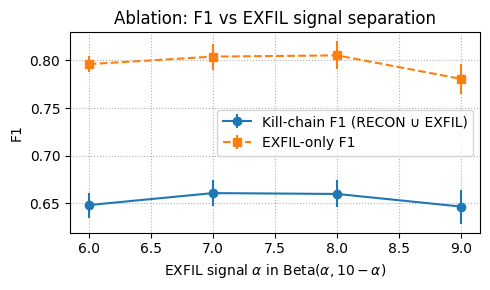

In [ ]:
# Example EXFIL ablation run
exfil_alpha_list = [6.0, 7.0, 8.0, 9.0]  # => Beta(6,4), (7,3), (8,2), (9,1)

N = 1000
pct_mal = 0.01
T = 30
f = 3
n_runs = 5

exfil_results = ablation_exfil_beta_vs_f1(
    exfil_alpha_list=exfil_alpha_list,
    num_users=N,
    pct_mal=pct_mal,
    horizon=T,
    ft=f,
    n_runs=n_runs,
)


             f1_kc_mean  f1_kc_se  f1_exfil_mean  f1_exfil_se
exfil_alpha                                                  
6.0            0.648022  0.013215       0.796137     0.008614
7.0            0.660632  0.013871       0.804043     0.013595
8.0            0.659725  0.014148       0.805338     0.014649
9.0            0.646433  0.017876       0.780565     0.015833


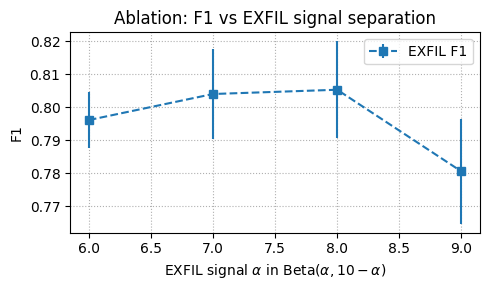

In [63]:

exfil_summary = summarize_exfil_beta_ablation(exfil_results)
print(exfil_summary)

# --- Plot, similar style as F1 vs traitors ---
fig, ax = plt.subplots(figsize=(5, 3))

xs = exfil_summary.index.values

ax.errorbar(
    xs,
    exfil_summary["f1_exfil_mean"].values,
    yerr=exfil_summary["f1_exfil_se"].values,
    marker="s",
    linestyle="--",
    label="EXFIL F1",
)

ax.set_xlabel(r"EXFIL signal $\alpha$ in $\mathrm{Beta}(\alpha, 10-\alpha)$")
ax.set_ylabel("F1")
ax.set_title("Ablation: F1 vs EXFIL signal separation")
ax.grid(True, linestyle=":")
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
def ablation_f1_vs_traitors(
    n_runs: int = 5,
    ft_values=(0, 3, 6, 9, 12),
    num_users=None,
    pct_mal=None,
    horizon=None,
) -> pd.DataFrame:
    """
    Ablate committee performance as a function of the number of
    Byzantine certifiers f (ft).

    Returns one row per (ft, seed) with:
      - f1_mal, FP_mal, FN_mal  : MALICIOUS-type period metrics at THRESHOLD
      - f1_kc, prec_kc, rec_kc  : kill-chain (RECON+EXFIL) period metrics
    """
    records = []
    for ft in ft_values:
        for seed in range(n_runs):
            df, metrics = run_single_simulation(
                behavior_mode="behavioral",
                agg_mode="anchor_clip",
                num_users=num_users,
                pct_mal=pct_mal,
                horizon=horizon,
                ft=ft,
                seed=seed,
            )

            agg = metrics["agg"]
            kc = compute_killchain_event_metrics(df, threshold=THRESHOLD)

            rec = {
                "ft": ft,
                "seed": seed,
                "obedience_rate": metrics["obedience_rate"],

                # MALICIOUS-type period metrics (at THRESHOLD)
                "f1_mal": agg["f1"],
                "FP_mal": agg["fp"],
                "FN_mal": agg["fn"],

                # Kill-chain (RECON ∪ EXFIL) period metrics (at THRESHOLD)
                "f1_kc": kc["f1_killchain"],
                "prec_kc": kc["precision_kc"],
                "rec_kc": kc["recall_kc"],
                "FP_kc": kc["fp_killchain"],
                "FN_kc": kc["fn_killchain"],
            }
            records.append(rec)

    return pd.DataFrame.from_records(records)
def summarize_f1_vs_traitors(df: pd.DataFrame) -> pd.DataFrame:
    grouped = df.groupby("ft")

    def mean_se(col: str) -> pd.DataFrame:
        m = grouped[col].mean()
        se = grouped[col].sem(ddof=1)
        out = pd.concat([m, se], axis=1)
        out.columns = [f"{col}_mean", f"{col}_se"]
        return out

    parts = [
        mean_se("f1_mal"),
        mean_se("FP_mal"),
        mean_se("FN_mal"),
        mean_se("f1_kc"),
        mean_se("prec_kc"),
        mean_se("rec_kc"),
        mean_se("FP_kc"),
        mean_se("FN_kc"),
    ]

    summary = pd.concat(parts, axis=1)
    return summary


In [66]:
# Example: match your usual CCS-ish setup
N = 1000
pct_mal = 0.01
T = 30
ft_values = [0, 3, 6, 9]   # keep ≤ committee size
n_runs = 5
EXFIL_ALPHA,  EXFIL_BETA  = 8.0, 2.0   # mean 0.80

trait_results = ablation_f1_vs_traitors(
    n_runs=n_runs,
    ft_values=ft_values,
    num_users=N,
    pct_mal=pct_mal,
    horizon=T,
)


Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 30 Steps
Running v21 Sim (Annotated CUSUM): 1000 Users, 3

,f1_mal_mean,f1_mal_se,FP_mal_mean,FP_mal_se,FN_mal_mean,FN_mal_se,f1_kc_mean,f1_kc_se,prec_kc_mean,prec_kc_se,rec_kc_mean,rec_kc_se,FP_kc_mean,FP_kc_se,FN_kc_mean,FN_kc_se
ft,,,,,,,,,,,,,,,,
0,0.829781,0.008979,0.6,0.400000,25.6,1.122497,0.663899,0.007669,0.993653,0.003911,0.498727,0.008896,0.4,0.244949,64.8,2.310844
3,0.805338,0.014649,0.4,0.244949,28.8,1.496663,0.659725,0.014148,0.992855,0.004377,0.494493,0.015240,0.4,0.244949,62.2,1.772005
6,0.782108,0.017210,0.6,0.400000,31.4,1.029563,0.643908,0.016515,0.995918,0.004082,0.476545,0.018154,0.2,0.200000,64.2,1.356466
9,0.794922,0.011477,0.4,0.244949,30.2,1.462874,0.646963,0.019838,0.996078,0.003922,0.480177,0.021278,0.2,0.200000,64.8,2.634388


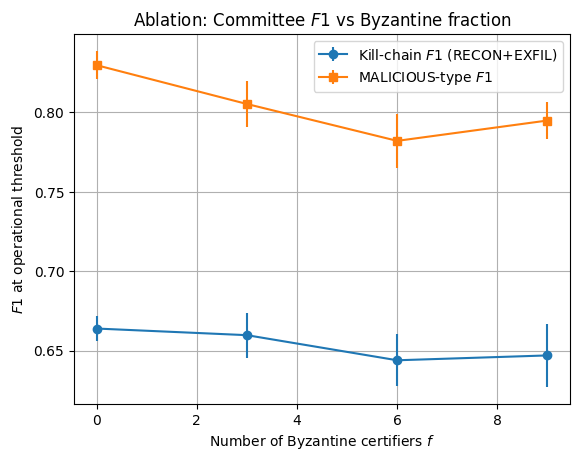

In [70]:

trait_summary = summarize_f1_vs_traitors(trait_results)
display(trait_summary)

# Plot F1 vs number of traitors
fts = trait_summary.index.values

plt.figure()
plt.errorbar(
    fts,
    trait_summary["f1_kc_mean"],
    yerr=trait_summary["f1_kc_se"],
    marker="o",
    label="Kill-chain $F1$ (RECON+EXFIL)",
)
plt.errorbar(
    fts,
    trait_summary["f1_mal_mean"],
    yerr=trait_summary["f1_mal_se"],
    marker="s",
    label="MALICIOUS-type $F1$",
)
plt.xlabel("Number of Byzantine certifiers $f$")
plt.ylabel("$F1$ at operational threshold")
plt.title("Ablation: Committee $F1$ vs Byzantine fraction")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ---- ROC: Behavioral, varying sparsity ----
num_runs = 3
N = 1000
T = 30
ft = 3

sparsities = [0.01, 0.05, 0.10]  # 1%, 5%, 10% malicious users

roc_curves = {}

for p in sparsities:
    y_p, s_p = collect_scores(
        num_runs=num_runs,
        behavior_mode="behavioral",
        num_users=N,
        pct_mal=p,
        horizon=T,
        ft=ft,
        seed_offset=int(p * 100_000),
    )
    curv_p = compute_curves(y_p, s_p)
    roc_curves[p] = curv_p
    base_prec_p = float(np.mean(y_p))
    print(f"pct_mal = {p:.2%}: ROC AUC = {curv_p['roc_auc']:.3f}, PR AUC = {curv_p['pr_auc']:.3f}, "
          f"base precision = {base_prec_p:.4f}")


plt.figure()
for p in sparsities:
    c = roc_curves[p]
    plt.plot(c["fpr"], c["tpr"],
             label=f"pct_mal = {p:.0%} (AUC = {c['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC: Behavioral Committee at Different Insider Prevalence Levels")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

# Assuming you *already* have:
# sparsities = [0.01, 0.05, 0.10]
# roc_curves = {p: compute_curves(...) ...} from your last cell

plt.figure()

for p in sparsities:
    c = roc_curves[p]
    prec = np.asarray(c["prec"])
    rec  = np.asarray(c["rec"])
    pr_auc = c["pr_auc"]
    plt.plot(rec, prec, label=f"pct_mal = {p:.0%} (PR AUC = {pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall: Behavioral Committee at Different Insider Prevalence Levels")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
for p in sparsities:
    c = roc_curves[p]
    print(f"pct_mal = {p:.2%} -> best F1 = {c['best_f1']:.3f} at thr ≈ {c['best_thr']:.3f}")


In [ ]:
# Example parameters roughly matching your CCS setup
N = 1000
pct_mal = 0.01
T = 30
f = 3

# 1. Behavioral vs rational
beh_results = ablation_behavior_vs_rational(
    n_runs=3,
    num_users=N,
    pct_mal=pct_mal,
    horizon=T,
    ft=f,
)
summary = summarize_behavior_vs_rational(beh_results)
summary


In [ ]:
# 2. Aggregator comparison
agg_results = ablation_aggregation_modes(
    n_runs=10,
    num_users=N,
    pct_mal=pct_mal,
    horizon=T,
    ft=f,
)
agg_results.groupby("agg_mode").mean()


In [ ]:
# 3. Threshold sweep
thr_results = ablation_thresholds(
    thresholds=(0.6, 0.75, 0.9),
    n_runs=10,
    num_users=N,
    pct_mal=pct_mal,
    horizon=T,
    ft=f,
)
thr_results.groupby("threshold").mean()
